# Simulate DeFi LP

Jupyter Notebook to simulate liquidity pools (LP) in Unisap v3. Pulls last 60 days of transaction for LP using a Dune Analytics query. Query pulls data for ETH-Stable pairs and Stable-Stable pairs (Only consiers DAI USDC and USDT). Builds a markov chain to forecast the next 7 days of tansactions for each pair.

In [124]:
# Setup
import torch
import dune_data_loader
# from markov_trainer import (RNN, MarkovChain)

### Get LP Data

In [125]:
# Query URL: https://dune.com/queries/2257465
# Query ID
qry_id = 2257465

dune_data = dune_data_loader.get_dune_data(2257465)
time_sereies = dune_data_loader.create_time_series(dune_data)

In [136]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Define the RNN architecture
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define the Markov chain class
class MarkovChain:
    def __init__(self, rnn, data):
        self.rnn = rnn
        self.data = data
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train(self, lr=0.001, epochs=100, batch_size=32, show=True):
        # Prepare the data
        seq_len = self.rnn.rnn.num_layers
        X = []
        Y = []
        for i in range(len(self.data) - seq_len):
            X.append(torch.tensor(self.data[i:i+seq_len]).float().unsqueeze(0))
            Y.append(torch.tensor(self.data[i+seq_len]).float().unsqueeze(0))
        X = torch.cat(X, dim=0)
        Y = torch.cat(Y, dim=0)

        # Move the data to the device
        X = X.to(self.device)
        Y = Y.to(self.device)

        # Instantiate the ADAM optimizer and the MSE loss function
        optimizer = optim.Adam(self.rnn.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Train the model
        for epoch in range(epochs):
            self.rnn.train()
            for i in range(0, len(X), batch_size):
                optimizer.zero_grad()
                batch_x = X[i:i+batch_size].view(-1, seq_len, 1)  # reshape the input tensor
                batch_y = Y[i:i+batch_size]
                output = self.rnn(batch_x)
                loss = criterion(output.squeeze(), Y[i:i+batch_size])
                loss.backward()
                optimizer.step()
            if show == True:
                if epoch % 10 == 0:
                    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

    def predict(self, x, n_steps=1):
        self.rnn.eval()
        x_test = torch.tensor(x).float().unsqueeze(0).unsqueeze(2)
        x_test = x_test.to(self.device)
        with torch.no_grad():
            y_pred = []
            for i in range(n_steps):
                output = self.rnn(x_test)
                y_pred.append(math.ceil(output.item()))
                x_test = torch.cat([x_test[:, 1:, :], output.unsqueeze(2)], dim=1)
        return y_pred
    
    def score(self, plot=False):
        # Make predictions
        y_true = torch.tensor(self.data[self.rnn.rnn.num_layers:]).to(self.device)
        y_pred = []
        mape_batch = []
        for i in range(0, len(self.data) - self.rnn.rnn.num_layers, 7):
            x = self.data[i:i+self.rnn.rnn.num_layers]
            x = torch.tensor(x).float().unsqueeze(0).unsqueeze(2).to(self.device)
            with torch.no_grad():
                output = self.rnn(x)
                y_pred.append(int(output.item()))
                mape_batch.append(torch.abs((y_true[i:i+7] - output.squeeze()) / y_true[i:i+7]) * 100)
        y_pred = torch.tensor(y_pred).to(self.device)
        mape_batch = torch.cat(mape_batch)
    
        # Calculate MAPE for each batch
        mape_batch = torch.abs((y_true[:len(y_pred)] - y_pred) / y_true[:len(y_pred)]) * 100

        # Calculate mean MAPE across all batches
        mape = torch.mean(mape_batch)

        # Print the metrics
        print(f"MAPE: {mape.item():.2f}%")

        # Plot the time series
        if plot:
            y_pred_all = y_pred.repeat(7).cpu().numpy()
            y_true_all = self.data[self.rnn.rnn.num_layers:]
            plt.plot(y_true_all, label="Actual")
            plt.plot(y_pred_all, label="Predicted")
            plt.legend()
            plt.show()
                
        return mape.item()

In [133]:
def optimize_model(data, n_hidden_layers_range, batch_size_range, n_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_mape = float("inf")
    best_n_hidden_layers = None
    best_batch_size = None
    best_model = None

    for n_hidden_layers in n_hidden_layers_range:
        for batch_size in batch_size_range:
            rnn = RNN(1, n_hidden_layers, 1).to(device)
            markov_chain = MarkovChain(rnn, data)

            # Train the model
            markov_chain.train(lr=0.001, epochs=n_epochs, batch_size=batch_size, show=False)

            # Evaluate the model
            mape = markov_chain.score()

            # Update the best parameters if necessary
            if mape < best_mape:
                best_mape = mape
                best_n_hidden_layers = n_hidden_layers
                best_batch_size = batch_size
                best_model = markov_chain

    print(f"Best MAPE: {best_mape:.2f}%")
    print(f"Best number of hidden layers: {best_n_hidden_layers}")
    print(f"Best batch size: {best_batch_size}")

    return best_model

In [134]:
# Prepare the data
data = time_sereies['ethereum']['DAI-USDC']

n_hidden_layers_range = range(1, 6)
batch_size_range = range(32, 129)
n_epochs = 100
best_model = optimize_model(data, n_hidden_layers_range, batch_size_range, n_epochs)


Epoch [1/100], Loss: 1704437.0000
Epoch [11/100], Loss: 1704351.8750
Epoch [21/100], Loss: 1704267.5000
Epoch [31/100], Loss: 1704183.1250
Epoch [41/100], Loss: 1704099.0000
Epoch [51/100], Loss: 1704015.0000
Epoch [61/100], Loss: 1703930.8750
Epoch [71/100], Loss: 1703846.8750
Epoch [81/100], Loss: 1703762.6250
Epoch [91/100], Loss: 1703678.6250
MAPE: 99.66%
Epoch [1/100], Loss: 1837232.7500
Epoch [11/100], Loss: 1837144.7500
Epoch [21/100], Loss: 1837056.8750
Epoch [31/100], Loss: 1836969.3750
Epoch [41/100], Loss: 1836882.0000
Epoch [51/100], Loss: 1836794.5000
Epoch [61/100], Loss: 1836707.0000
Epoch [71/100], Loss: 1836619.8750
Epoch [81/100], Loss: 1836532.7500
Epoch [91/100], Loss: 1836445.3750
MAPE: 99.32%
Epoch [1/100], Loss: 1998518.2500
Epoch [11/100], Loss: 1998426.0000
Epoch [21/100], Loss: 1998334.6250
Epoch [31/100], Loss: 1998243.0000
Epoch [41/100], Loss: 1998151.5000
Epoch [51/100], Loss: 1998059.8750
Epoch [61/100], Loss: 1997968.3750
Epoch [71/100], Loss: 1997877.12

/home/carlos/anaconda3/envs/DeFiSim/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [21/100], Loss: 207501.7188
Epoch [31/100], Loss: 207465.2969
Epoch [41/100], Loss: 207428.8438
Epoch [51/100], Loss: 207392.4375
Epoch [61/100], Loss: 207356.0312
Epoch [71/100], Loss: 207319.6094
Epoch [81/100], Loss: 207283.2188
Epoch [91/100], Loss: 207246.8125
MAPE: 100.00%
Epoch [1/100], Loss: 593305.1875
Epoch [11/100], Loss: 593286.2500
Epoch [21/100], Loss: 593267.3750
Epoch [31/100], Loss: 593248.3125
Epoch [41/100], Loss: 593229.3750
Epoch [51/100], Loss: 593210.4375
Epoch [61/100], Loss: 593191.5000
Epoch [71/100], Loss: 593172.4375
Epoch [81/100], Loss: 593153.5000
Epoch [91/100], Loss: 593134.5625
MAPE: 100.00%
Epoch [1/100], Loss: 594175.3125
Epoch [11/100], Loss: 594156.2500
Epoch [21/100], Loss: 594137.3125
Epoch [31/100], Loss: 594118.3125
Epoch [41/100], Loss: 594099.3750
Epoch [51/100], Loss: 594080.3125
Epoch [61/100], Loss: 594061.3750
Epoch [71/100], Loss: 594042.3125
Epoch [81/100], Loss: 594023.3125
Epoch [91/100], Loss: 594004.3125
MAPE: 100.34%
Epoch [1

In [122]:

# Set the hyperparameters
input_size = 1
hidden_size = 10
output_size = 1
lr = 0.001
epochs = 100
batch_size = 32

# Set up the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the data
data = time_sereies['ethereum']['DAI-USDC']

# Instantiate the RNN model and the Markov chain
model = RNN(input_size, hidden_size, output_size)
model.to(device)
markov_chain = MarkovChain(model, data)

# Train the model on the GPU
markov_chain.train(lr=lr, epochs=epochs, batch_size=batch_size)


Epoch [1/100], Loss: 1703206.5000
Epoch [11/100], Loss: 1702364.8750
Epoch [21/100], Loss: 1701908.1250
Epoch [31/100], Loss: 1701447.8750
Epoch [41/100], Loss: 1700988.6250
Epoch [51/100], Loss: 1700530.6250
Epoch [61/100], Loss: 1700073.1250
Epoch [71/100], Loss: 1699616.1250
Epoch [81/100], Loss: 1699159.5000
Epoch [91/100], Loss: 1698703.2500


MAPE: 98.99%


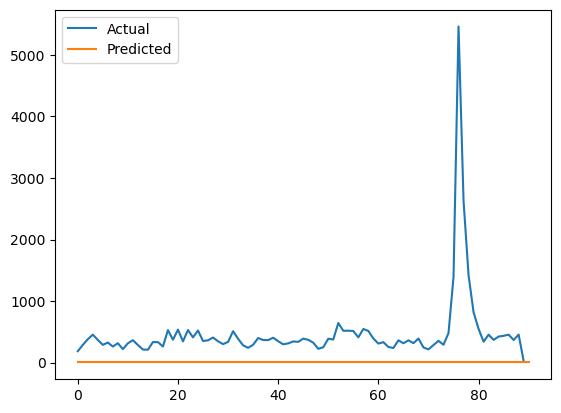

98.98760223388672

In [59]:

# Make a prediction
l = len(time_sereies['ethereum']['DAI-USDC'])
x_test = [time_sereies['ethereum']['DAI-USDC'][-1]]
#x_test = x_test = [[6]]
y_pred = markov_chain.predict(x_test, 10, device=device)
print("Prediction: ", y_pred)

Prediction:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [38]:
time_sereies['ethereum']['DAI-USDC'][-1]

25